In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import time
import optax
import matplotlib.pyplot as plt 
from jax.flatten_util import ravel_pytree
from functools import partial
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import piml_library.lagrangian as lag
import piml_library.hamiltonian as ham
import piml_library.util as util
import piml_library.early_stopping as es
import piml_library.plotting as plotting
from piml_library.hnn import (
    HamiltonianNN, 
    compute_loss, 
    train_step, 
    create_trajectory,
    create_trajectory_for_lnn
)
import dataset_generator as dg

In [2]:
@jax.jit
#L((t, q, v))
def L_analytical(state):
    q = lag.coordinate(state)
    v = lag.velocity(state)
    q_flat, _ = ravel_pytree(q)
    v_flat, _ = ravel_pytree(v)
    
    T = 0.5 * jnp.sum(v_flat**2)
    V = 0.5 * jnp.sum(q_flat**2)
    return T - V

In [3]:
@jax.jit
#H((t, q, p))
def H_analytical(state, m=1.0, k=1.0):
    q = ham.coordinate(state) 
    p = ham.momentum(state) 
    
    q_flat, _ = ravel_pytree(q) 
    p_flat, _ = ravel_pytree(p) 
    
    T = 0.5 / m * jnp.sum(p_flat**2) 
    V = 0.5 * k * jnp.sum(q_flat**2) 
    return T + V 

In [4]:
# --- ハイパーパラメータ ---
q_dim = 1      
hidden_dim = 200
learning_rate = 1e-2
num_epochs = 30000
key = jax.random.PRNGKey(8)

# --- setup trajectory of training and test data ---
num_trajectories = 100  # 学習用の軌道数
N_points_per_traj = 30      # 1軌道あたりの点の数
t_end = 3.0             # 1軌道のシミュレーション時間
t_eval = jnp.linspace(0.0, t_end, N_points_per_traj)

# 学習用とテスト用の時間分割 (50%を学習用)
split_ratio = 0.5
N_points_train = int(N_points_per_traj * split_ratio)


--- 学習用・テスト用データセットの生成開始 ---
Generating 100 trajectories...
--- データセット生成完了 ---
Total Train Points: 1500
Total Test Points:  1500


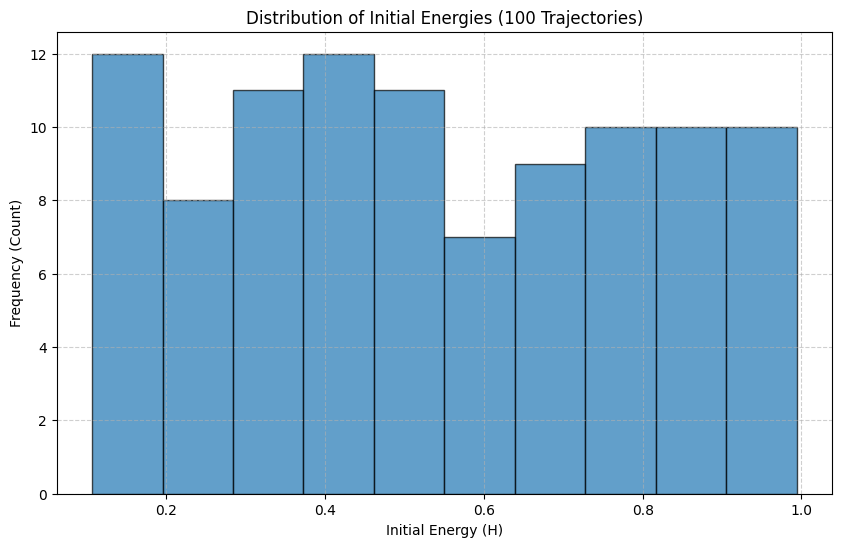

In [5]:
# --- モジュールの関数を呼び出してデータを生成 ---
data_dict = dg.create_trajectory_datasets(
    L_analytical, 
    H_analytical,
    key,
    q_dim=q_dim,
    num_trajectories=num_trajectories,
    N_points_per_traj=N_points_per_traj,
    t_end=t_end,
    split_ratio=split_ratio
)

train_states = data_dict["train_states_hnn"]
train_t, train_q, train_p = train_states
train_targets = data_dict["train_targets_hnn"]
train_q_dot_true, train_p_dot_true = train_targets

test_dataset_states = data_dict["test_dataset_states_hnn"]
test_t, test_q, test_p = test_dataset_states
test_dataset_true_derivatives = data_dict["test_dataset_targets_hnn"]


initial_energies = data_dict["initial_energies"]
N_train_total = data_dict["N_train_total"]

key, _ = jax.random.split(key) 

energies_np = np.array(initial_energies)

plt.figure(figsize=(10, 6))
plt.hist(energies_np, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Initial Energy (H)')
plt.ylabel('Frequency (Count)')
plt.title(f'Distribution of Initial Energies ({num_trajectories} Trajectories)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [6]:
'''
learning Process
'''

# --- モデルとオプティマイザの初期化 ---
hnn_model = HamiltonianNN(hidden_dim=hidden_dim, out_dim=q_dim)
model_apply_fn = hnn_model.apply  
true_derivatives = ham.state_derivative(H_analytical)
vmap_true_derivatives = jax.vmap(
    lambda t, q, p: true_derivatives((t, q, p)),
    in_axes=(0,0,0)
)

key, init_key = jax.random.split(key) #同じkeyを与えると同じ値を毎回与える

# モデルを初期化するためのダミー入力 (t, q, v)
# q と v は q_dim に合わせる
dummy_q = jnp.zeros((q_dim,))
dummy_p = jnp.zeros((q_dim,))
dummy_state = (0.0, dummy_q, dummy_p)

params = hnn_model.init(init_key, dummy_state)['params'] #構造を決定
optimizer = optax.adamw(learning_rate, weight_decay=1e-4)
opt_state = optimizer.init(params) #重みを追跡するために必要な内部メモリ状態
es = es.EarlyStopping(patience=100, verbose=True, path='best_lnn_params.pkl', mode='min', save_best_on_disk=False)

print("モデルとオプティマイザの初期化完了。学習を開始します...")

start_train_time = time.time()

# ミニバッチのサイズ
batch_size = 256 

# --- 学習ループ ---
for epoch in range(num_epochs):
    
    '''
    # randomly choose trajectory 
    key, data_key = jax.random.split(key)
    indices = jax.random.choice(data_key, N_train_total, shape=(batch_size,), replace=False)
    
    # make mini batch
    batch_states = (train_t[indices], train_q[indices], train_p[indices])
    batch_true_derivatives = (train_q_dot_true[indices], train_p_dot_true[indices])
    '''
    
    params, opt_state, train_loss = train_step(
        params, 
        opt_state, 
        optimizer, 
        model_apply_fn, 
        train_states, 
        train_targets
    )
    
    check_interval = 10
    
    if epoch % check_interval == 0:
        test_loss = compute_loss(
            params,
            model_apply_fn,
            test_dataset_states,
            test_dataset_true_derivatives
        )
        
        if epoch % 100 == 0:
             print(f"Epoch {epoch}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")
        
        es(test_loss, params)
        if es.early_stop:
            print(f"Early stopping triggered at epoch {epoch}")
            break

print("学習完了。")
final_params = es.best_params

# Final Test Loss
final_test_loss = compute_loss(final_params, model_apply_fn, test_dataset_states, test_dataset_true_derivatives)
final_test_loss.block_until_ready()
end_train_time = time.time()
print(f"--- Final Test Loss: {final_test_loss:.6f} ---")
print(f"--- Total Training Time: {end_train_time - start_train_time:.2f} seconds ---")

モデルとオプティマイザの初期化完了。学習を開始します...
Epoch 0, Train Loss: 0.290741, Test Loss: 3.857723
Validation metric set to 3.857723.  Saving model ...
Validation metric improved from 3.857723 to 0.171658.  Saving model ...
Validation metric improved from 0.171658 to 0.034079.  Saving model ...
Validation metric improved from 0.034079 to 0.008604.  Saving model ...
Validation metric improved from 0.008604 to 0.002772.  Saving model ...
Validation metric improved from 0.002772 to 0.001016.  Saving model ...
Validation metric improved from 0.001016 to 0.000539.  Saving model ...
Validation metric improved from 0.000539 to 0.000285.  Saving model ...
Validation metric improved from 0.000285 to 0.000251.  Saving model ...
Validation metric improved from 0.000251 to 0.000208.  Saving model ...
Epoch 100, Train Loss: 0.000182, Test Loss: 0.000196
Validation metric improved from 0.000208 to 0.000196.  Saving model ...
Validation metric improved from 0.000196 to 0.000196.  Saving model ...
Validation metric imp

In [7]:
'''
generate trajectory
'''
HNN_fn = lambda s: model_apply_fn({'params': final_params}, s) 
LNN_from_HNN_fn = ham.hamiltonian_to_lagrangian(HNN_fn)

lag_to_ham_state_fn_true = ham.lagrangian_state_to_hamiltonian_state(L_analytical)
ham_to_lag_state_fn_true = ham.hamiltonian_state_to_lagrangian_state(H_analytical)
lag_to_ham_state_fn_learned = ham.lagrangian_state_to_hamiltonian_state(LNN_from_HNN_fn)
ham_to_lag_state_fn_learned = ham.hamiltonian_state_to_lagrangian_state(HNN_fn)

solver_learned_hnn = create_trajectory(model_apply_fn, final_params)
solver_learned_lnn_from_hnn = create_trajectory_for_lnn(LNN_from_HNN_fn)

# Initial state (t=0, q=1.0, p=0.0)
initial_state_ham = (0.0, jnp.array([1.0]), jnp.array([0.0]))
initial_state_lag = (0.0, jnp.array([1.0]), jnp.array([0.0]))
t_eval = jnp.linspace(0.0, 100.0, 10000) 

#true
ds_true = ham.state_derivative(H_analytical)
solver_true = util.ode_solver(ds_true)
ham_states_true = solver_true(initial_state_ham, t_eval) 
lag_states_true = jax.vmap(ham_to_lag_state_fn_true)(ham_states_true)

#HNN
ham_states_learned_hnn = solver_learned_hnn(initial_state_ham, t_eval) #HNNから生成された軌道
lag_states_learned_hnn = jax.vmap(ham_to_lag_state_fn_true)(ham_states_learned_hnn)

#LNN_from_HNN
v_learned_init_fn = ham.hamiltonian_state_to_lagrangian_state(HNN_fn)
initial_state_lnn_learned = v_learned_init_fn(initial_state_ham)
lag_states_learned_lnn_from_hnn = solver_learned_lnn_from_hnn(initial_state_lnn_learned, t_eval)
ham_states_learned_lnn_from_hnn = jax.vmap(lag_to_ham_state_fn_learned)(lag_states_learned_lnn_from_hnn) #ここでリスケールが完了する
lag_states_learned_lnn_from_hnn = jax.vmap(ham_to_lag_state_fn_true)(ham_states_learned_lnn_from_hnn)

start_inference_time = time.time()
ham_states_learned_hnn[1].block_until_ready() 
end_inference_time = time.time()
print(f"--- Trajectory Inference Time: {end_inference_time - start_inference_time:.4f} seconds ---")
print("軌道生成が完了しました。")

--- Trajectory Inference Time: 0.0001 seconds ---
軌道生成が完了しました。


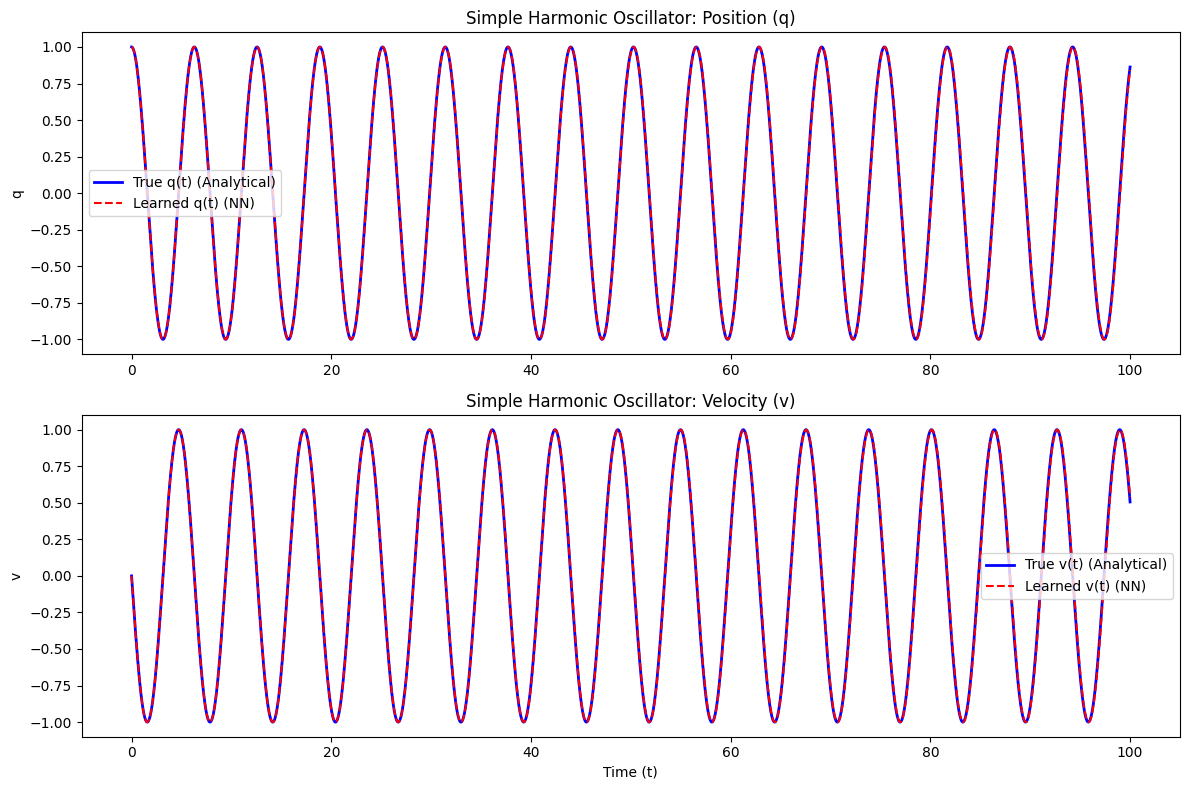

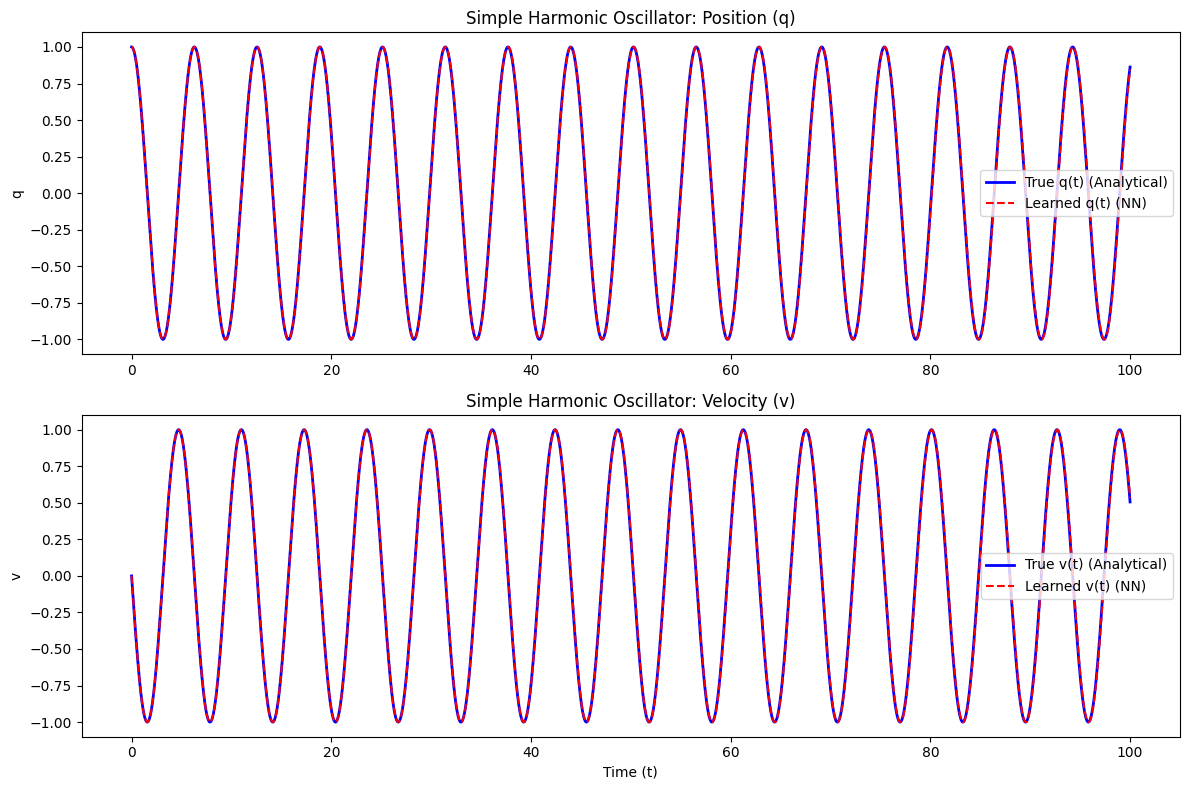

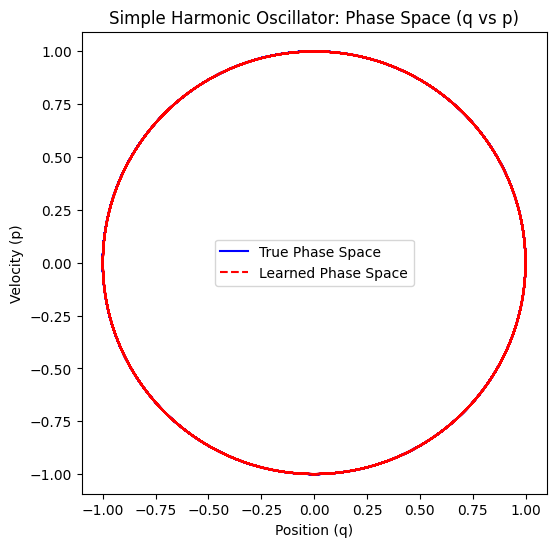

In [8]:
''' 
plot result
'''

#true
t_true, q_true, p_true = ham_states_true
v_true = lag_states_true[2]

#HNN
t_learned_hnn, q_learned_hnn, p_learned_hnn = ham_states_learned_hnn
v_learned_hnn = lag_states_learned_hnn[2]

#LNN_from_HNN
t_learned_lnn_from_hnn, q_learned_lnn_from_hnn, v_learned_lnn_from_hnn = lag_states_learned_lnn_from_hnn
p_learned_lnn_from_hnn = ham_states_learned_lnn_from_hnn[2]

title_prefix="Simple Harmonic Oscillator:"
plotting.plot_trajectory_comparison(
    t_true, q_true, v_true, 
    t_learned_hnn, q_learned_hnn, v_learned_hnn,
    title_prefix
)

plotting.plot_trajectory_comparison(
    t_true, q_true, v_true, 
    t_learned_lnn_from_hnn, q_learned_lnn_from_hnn, v_learned_lnn_from_hnn,
    title_prefix
)

plotting.plot_phase_space(
    q_true, p_true, 
    q_learned_hnn, p_learned_hnn,
    title_prefix
    )

In [9]:
np.savez(
    "results_H1D_HNN.npz", 
    t_true_hnn=np.array(t_true),
    q_true_hnn=np.array(q_true),
    v_true_hnn=np.array(v_true),
    p_true_hnn=np.array(p_true),
    
    t_learned_hnn=np.array(t_learned_hnn),
    q_learned_hnn=np.array(q_learned_hnn),
    v_learned_hnn=np.array(v_learned_hnn),
    p_learned_hnn=np.array(p_learned_hnn),
    
    t_learned_lnn_from_hnn=np.array(t_learned_lnn_from_hnn),
    q_learned_lnn_from_hnn=np.array(q_learned_lnn_from_hnn),
    v_learned_lnn_from_hnn=np.array(v_learned_lnn_from_hnn),
    p_learned_lnn_from_hnn=np.array(p_learned_lnn_from_hnn),
)